In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-AB-RBF-TRB_HUMAN-after-reassignment.csv']

In [23]:
pt_file="20180326_RUN25_pt.table.csv"
plotfile="run25-" + celltype + '.pdf'
suspects_list = "run25-" + celltype + ".txt"

## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,read_perc,umi_perc
0,AB-RBF002-Tu_S1,ACGTACGT,CASSAVAGGYNEQFFG,574,517,TRBV6-2+TRBV6-3,"TRBJ2-1,TRBJ2-5,TRBJ2-7",0.876577,0.992056
1,AB-RBF002-Tu_S1,ACGTACGT,CASSLVTDTQYFG,419,333,TRBV11-2,TRBJ2-3,0.639870,0.638984
2,AB-RBF002-Tu_S1,ACGTACGT,CSGARGEGTEAFFG,327,216,TRBV29-1,TRBJ1-1,0.499374,0.414476
3,AB-RBF002-Tu_S1,ACGTACGT,CASSTSPRGYTFG,311,247,TRBV19,TRBJ1-2,0.474940,0.473961
4,AB-RBF002-Tu_S1,ACGTACGT,CSVEEGGYTFG,297,189,TRBV29-1,TRBJ1-2,0.453560,0.362666


## Import patient table

In [6]:
pt = pd.read_csv(pt_file, sep=";")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Samples order,Sample_ID,Sample name,Project,Species,Chain,Patient,SampleInfo,UMI (yes or no),Unnamed: 9
0,S1,N701_S502,AB-RBF002-Tu,AB-RBF,human,TCRb,17-02-0005,V8_M12,YES,NaN
1,S2,N702_S502,AB-RBF003-Tu,AB-RBF,human,TCRb,17-02-0005,V5_M3,YES,NaN
2,S3,N703_S502,AB-RBF007-Tu,AB-RBF,human,TCRb,17-02-0005,V3_M1,YES,NaN
3,S4,N704_S502,AB-RBF009-Tu,AB-RBF,human,TCRb,17-02-0005,V9_M18,YES,NaN
4,S5,N705_S502,AB-RBF012-Tu,AB-RBF,human,TCRb,28-01-0027,V6_M6,YES,NaN


In [7]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [8]:
pt.head()

,Sample,Patient
0,AB-RBF002-Tu_S1,17-02-0005
1,AB-RBF003-Tu_S2,17-02-0005
2,AB-RBF007-Tu_S3,17-02-0005
3,AB-RBF009-Tu_S4,17-02-0005
4,AB-RBF012-Tu_S5,28-01-0027


## Merge clones with pt

In [9]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,read_perc,umi_perc,Patient
0,AB-RBF002-Tu_S1,ACGTACGT,CASSAVAGGYNEQFFG,574,517,TRBV6-2+TRBV6-3,"TRBJ2-1,TRBJ2-5,TRBJ2-7",0.876577,0.992056,17-02-0005
1,AB-RBF002-Tu_S1,ACGTACGT,CASSLVTDTQYFG,419,333,TRBV11-2,TRBJ2-3,0.639870,0.638984,17-02-0005
2,AB-RBF002-Tu_S1,ACGTACGT,CSGARGEGTEAFFG,327,216,TRBV29-1,TRBJ1-1,0.499374,0.414476,17-02-0005
3,AB-RBF002-Tu_S1,ACGTACGT,CASSTSPRGYTFG,311,247,TRBV19,TRBJ1-2,0.474940,0.473961,17-02-0005
4,AB-RBF002-Tu_S1,ACGTACGT,CSVEEGGYTFG,297,189,TRBV29-1,TRBJ1-2,0.453560,0.362666,17-02-0005


## Determine distance between samples

In [10]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(value=0)
df_pivot.head()

Patient                  17-02-0001        17-02-0002      17-02-0005  \
Sample             AB-RBF207-Tu_S98 AB-RBF208-Tu_S115 AB-RBF002-Tu_S1   
cdr3pep                                                                 
CAAAAGGTADTQYFG                 0.0               0.0             0.0   
CAAAAGGTDTQYFG                  0.0               0.0             0.0   
CAAAAGGTEAFFG                   0.0               0.0             0.0   
CAAAAGRTSGGWNEQFFG              0.0               0.0             0.0   
CAAAAGYLYEQYFG                  0.0               0.0             0.0   

Patient                                                             \
Sample             AB-RBF003-Tu_S2 AB-RBF007-Tu_S3 AB-RBF009-Tu_S4   
cdr3pep                                                              
CAAAAGGTADTQYFG                0.0             0.0             0.0   
CAAAAGGTDTQYFG                 0.0             0.0             0.0   
CAAAAGGTEAFFG                  0.0             0.0             0.0   
CAAAAGRTSGGWNEQFFG             0.0             0.0             0.0   
CAAAAGYLYEQYFG                 0.0             0.0             0.0   

Patient                   17-02-0006        17-03-0002       18-01-0003  \
Sample             AB-RBF209-Tu_S116 AB-RBF210-Tu_S117 AB-RBF163-Tu_S47   
cdr3pep                                                                   
CAAAAGGTADTQYFG                  0.0               0.0              0.0   
CAAAAGGTDTQYFG                   0.0               0.0              0.0   
CAAAAGGTEAFFG                    0.0               0.0              0.0   
CAAAAGRTSGGWNEQFFG               0.0               0.0              0.0   
CAAAAGYLYEQYFG                   0.0               0.0              0.0   

Patient                                     ...              28-01-0036  \
Sample             AB-RBF171-Tu_S183        ...        AB-RBF066-Tu_S62   
cdr3pep                                     ...                           
CAAAAGGTADTQYFG                  0.0        ...                     0.0   
CAAAAGGTDTQYFG                   0.0        ...                     0.0   
CAAAAGGTEAFFG                    0.0        ...                     0.0   
CAAAAGRTSGGWNEQFFG               0.0        ...                     0.0   
CAAAAGYLYEQYFG                   0.0        ...                     0.0   

Patient                                    28-01-0037       28-01-0045  \
Sample             AB-RBF071-Tu_S65 AB-RBF223-Tu_S146 AB-RBF045-Tu_S44   
cdr3pep                                                                  
CAAAAGGTADTQYFG                 0.0               0.0              0.0   
CAAAAGGTDTQYFG                  0.0               0.0              0.0   
CAAAAGGTEAFFG                   0.0               0.0              0.0   
CAAAAGRTSGGWNEQFFG              0.0               0.0              0.0   
CAAAAGYLYEQYFG                  0.0               0.0              0.0   

Patient                                                                \
Sample             AB-RBF057-Tu_S45 AB-RBF068-Tu_S63 AB-RBF069-Tu_S64   
cdr3pep                                                                 
CAAAAGGTADTQYFG                 0.0              0.0              0.0   
CAAAAGGTDTQYFG                  0.0              0.0              0.0   
CAAAAGGTEAFFG                   0.0              0.0              0.0   
CAAAAGRTSGGWNEQFFG              0.0              0.0              0.0   
CAAAAGYLYEQYFG                  0.0              0.0              0.0   

Patient                                    28-01-0047        28-01-0048  
Sample             AB-RBF072-Tu_S66 AB-RBF227-Tu_S166 AB-RBF231-Tu_S170  
cdr3pep                                                                  
CAAAAGGTADTQYFG                 0.0               0.0               0.0  
CAAAAGGTDTQYFG                  0.0               0.0               0.0  
CAAAAGGTEAFFG                   0.0               0.0               0.0  
CAAAAGRTSGGWNEQFFG            

In [11]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                            17-02-0001        17-02-0002  \
Sample                       AB-RBF207-Tu_S98 AB-RBF208-Tu_S115   
Patient    Sample                                                 
17-02-0001 AB-RBF207-Tu_S98          1.000000          0.011497   
17-02-0002 AB-RBF208-Tu_S115         0.011497          1.000000   
17-02-0005 AB-RBF002-Tu_S1           0.015709          0.013173   
           AB-RBF003-Tu_S2           0.013020          0.011833   
           AB-RBF007-Tu_S3           0.013915          0.012046   

Patient                           17-02-0005                                  \
Sample                       AB-RBF002-Tu_S1 AB-RBF003-Tu_S2 AB-RBF007-Tu_S3   
Patient    Sample                                                              
17-02-0001 AB-RBF207-Tu_S98         0.015709        0.013020        0.013915   
17-02-0002 AB-RBF208-Tu_S115        0.013173        0.011833        0.012046   
17-02-0005 AB-RBF002-Tu_S1          1.000000        0.142940        0.161890   
           AB-RBF003-Tu_S2          0.142940        1.000000        0.131531   
           AB-RBF007-Tu_S3          0.161890        0.131531        1.000000   

Patient                                             17-02-0006  \
Sample                       AB-RBF009-Tu_S4 AB-RBF209-Tu_S116   
Patient    Sample                                                
17-02-0001 AB-RBF207-Tu_S98         0.014284          0.011711   
17-02-0002 AB-RBF208-Tu_S115        0.012613          0.011479   
17-02-0005 AB-RBF002-Tu_S1          0.178233          0.013292   
           AB-RBF003-Tu_S2          0.154393          0.010783   
           AB-RBF007-Tu_S3          0.147642          0.011990   

Patient                             17-03-0002       18-01-0003  \
Sample                       AB-RBF210-Tu_S117 AB-RBF163-Tu_S47   
Patient    Sample                                                 
17-02-0001 AB-RBF207-Tu_S98           0.015575         0.012907   
17-02-0002 AB-RBF208-Tu_S115          0.012441         0.012574   
17-02-0005 AB-RBF002-Tu_S1            0.016085         0.014623   
           AB-RBF003-Tu_S2            0.015172         0.013618   
           AB-RBF007-Tu_S3            0.015473         0.013315   

Patient                                               ...         \
Sample                       AB-RBF171-Tu_S183        ...          
Patient    Sample                                     ...          
17-02-0001 AB-RBF207-Tu_S98           0.012635        ...          
17-02-0002 AB-RBF208-Tu_S115          0.012890        ...          
17-02-0005 AB-RBF002-Tu_S1            0.014019        ...          
           AB-RBF003-Tu_S2            0.014090        ...          
           AB-RBF007-Tu_S3            0.013845        ...          

Patient                            28-01-0036                   \
Sample                       AB-RBF066-Tu_S62 AB-RBF071-Tu_S65   
Patient    Sample                                                
17-02-0001 AB-RBF207-Tu_S98          0.013317         0.012330   
17-02-0002 AB-RBF208-Tu_S115         0.012580         0.011469   
17-02-0005 AB-RBF002-Tu_S1           0.014644         0.013123   
           AB-RBF003-Tu_S2           0.015677         0.013694   
           AB-RBF007-Tu_S3           0.012808         0.012554   

Patient                             28-01-0037       28-01-0045  \
Sample                       AB-RBF223-Tu_S146 AB-RBF045-Tu_S44   
Patient    Sample                                                 
17-02-0001 AB-RBF207-Tu_S98           0.009445         0.009346   
17-02-0002 AB-RBF208-Tu_S115          0.011469         0.010935   
17-02-0005 AB-RBF002-Tu_S1            0.011086         0.010465   
           AB-RBF003-Tu_S2            0.010583         0.010854   
           AB-RBF007-Tu_S3            0.010024         0.009391   

Patient                                                         \
Sample                       AB-RBF057-Tu_S45 AB-RBF068-Tu_S63   
Patient    Sa

## Create a heatmap

In [12]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [13]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

Wrote run25-TRB_HUMAN.pdf to disk


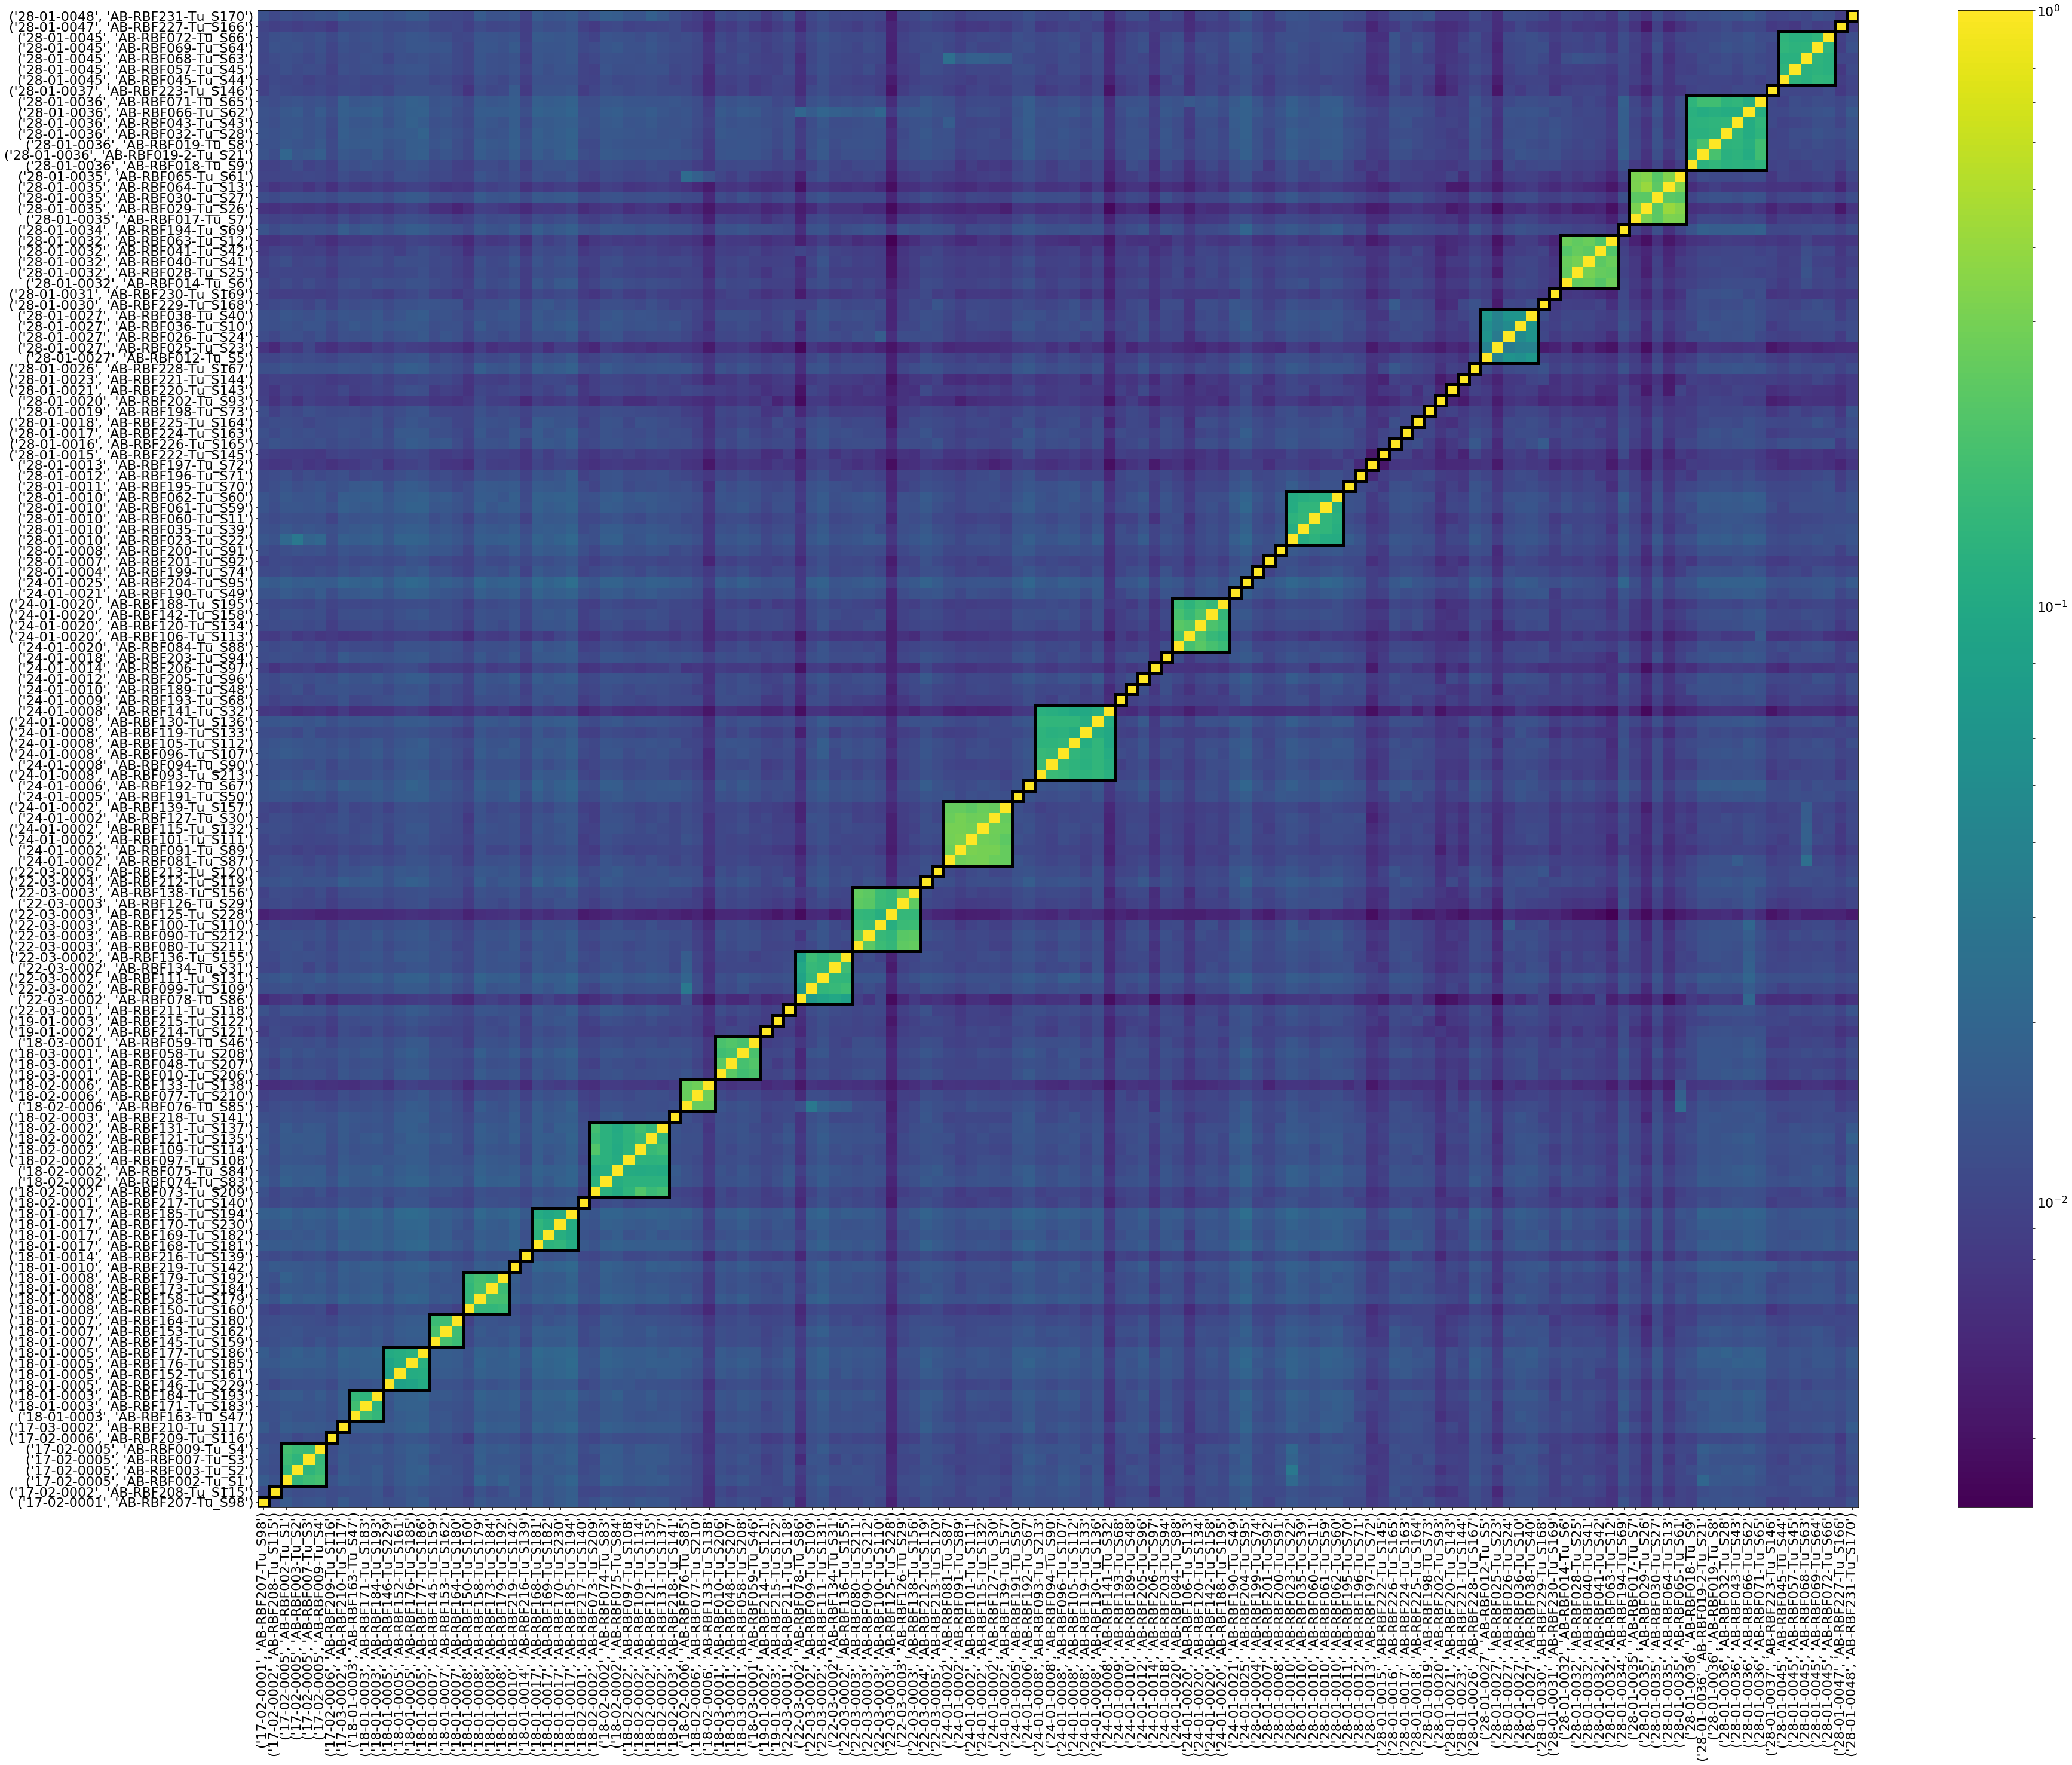

In [14]:
drawHeatmap(sim)

## Highlight anomalies

In [15]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [16]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.16068228697420384 0.06689268287014596
mean diff patient 0.01118519842161672 0.0028693621674560563
threshold 0.022662647091440946


In [17]:
a, b = st.t.interval(0.95, len(values_diff_patient)-1, loc=np.mean(values_diff_patient), scale=st.sem(values_diff_patient))
print(a,b)

0.01114445508713052 0.011225941756102918


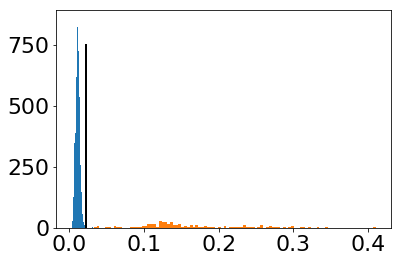

In [18]:
# Boxplot
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [24]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()

('17-02-0005', 'AB-RBF003-Tu_S2') ('28-01-0010', 'AB-RBF023-Tu_S22') 0.03099807967871171
('18-01-0005', 'AB-RBF176-Tu_S185') ('18-01-0017', 'AB-RBF185-Tu_S194') 0.022898174927695192
('18-01-0017', 'AB-RBF185-Tu_S194') ('18-01-0005', 'AB-RBF176-Tu_S185') 0.022898174927695192
('18-01-0017', 'AB-RBF185-Tu_S194') ('24-01-0025', 'AB-RBF204-Tu_S95') 0.024879331772594604
('18-02-0006', 'AB-RBF076-Tu_S85') ('22-03-0002', 'AB-RBF099-Tu_S109') 0.031114706358194466
('22-03-0002', 'AB-RBF099-Tu_S109') ('18-02-0006', 'AB-RBF076-Tu_S85') 0.031114706358194466
('24-01-0002', 'AB-RBF081-Tu_S87') ('28-01-0045', 'AB-RBF068-Tu_S63') 0.02494317502093557
('24-01-0025', 'AB-RBF204-Tu_S95') ('18-01-0017', 'AB-RBF185-Tu_S194') 0.024879331772594604
('28-01-0010', 'AB-RBF023-Tu_S22') ('17-02-0005', 'AB-RBF003-Tu_S2') 0.03099807967871171
('28-01-0045', 'AB-RBF068-Tu_S63') ('24-01-0002', 'AB-RBF081-Tu_S87') 0.02494317502093557


In [20]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

Wrote run25-TRB_HUMAN-2.pdf to disk


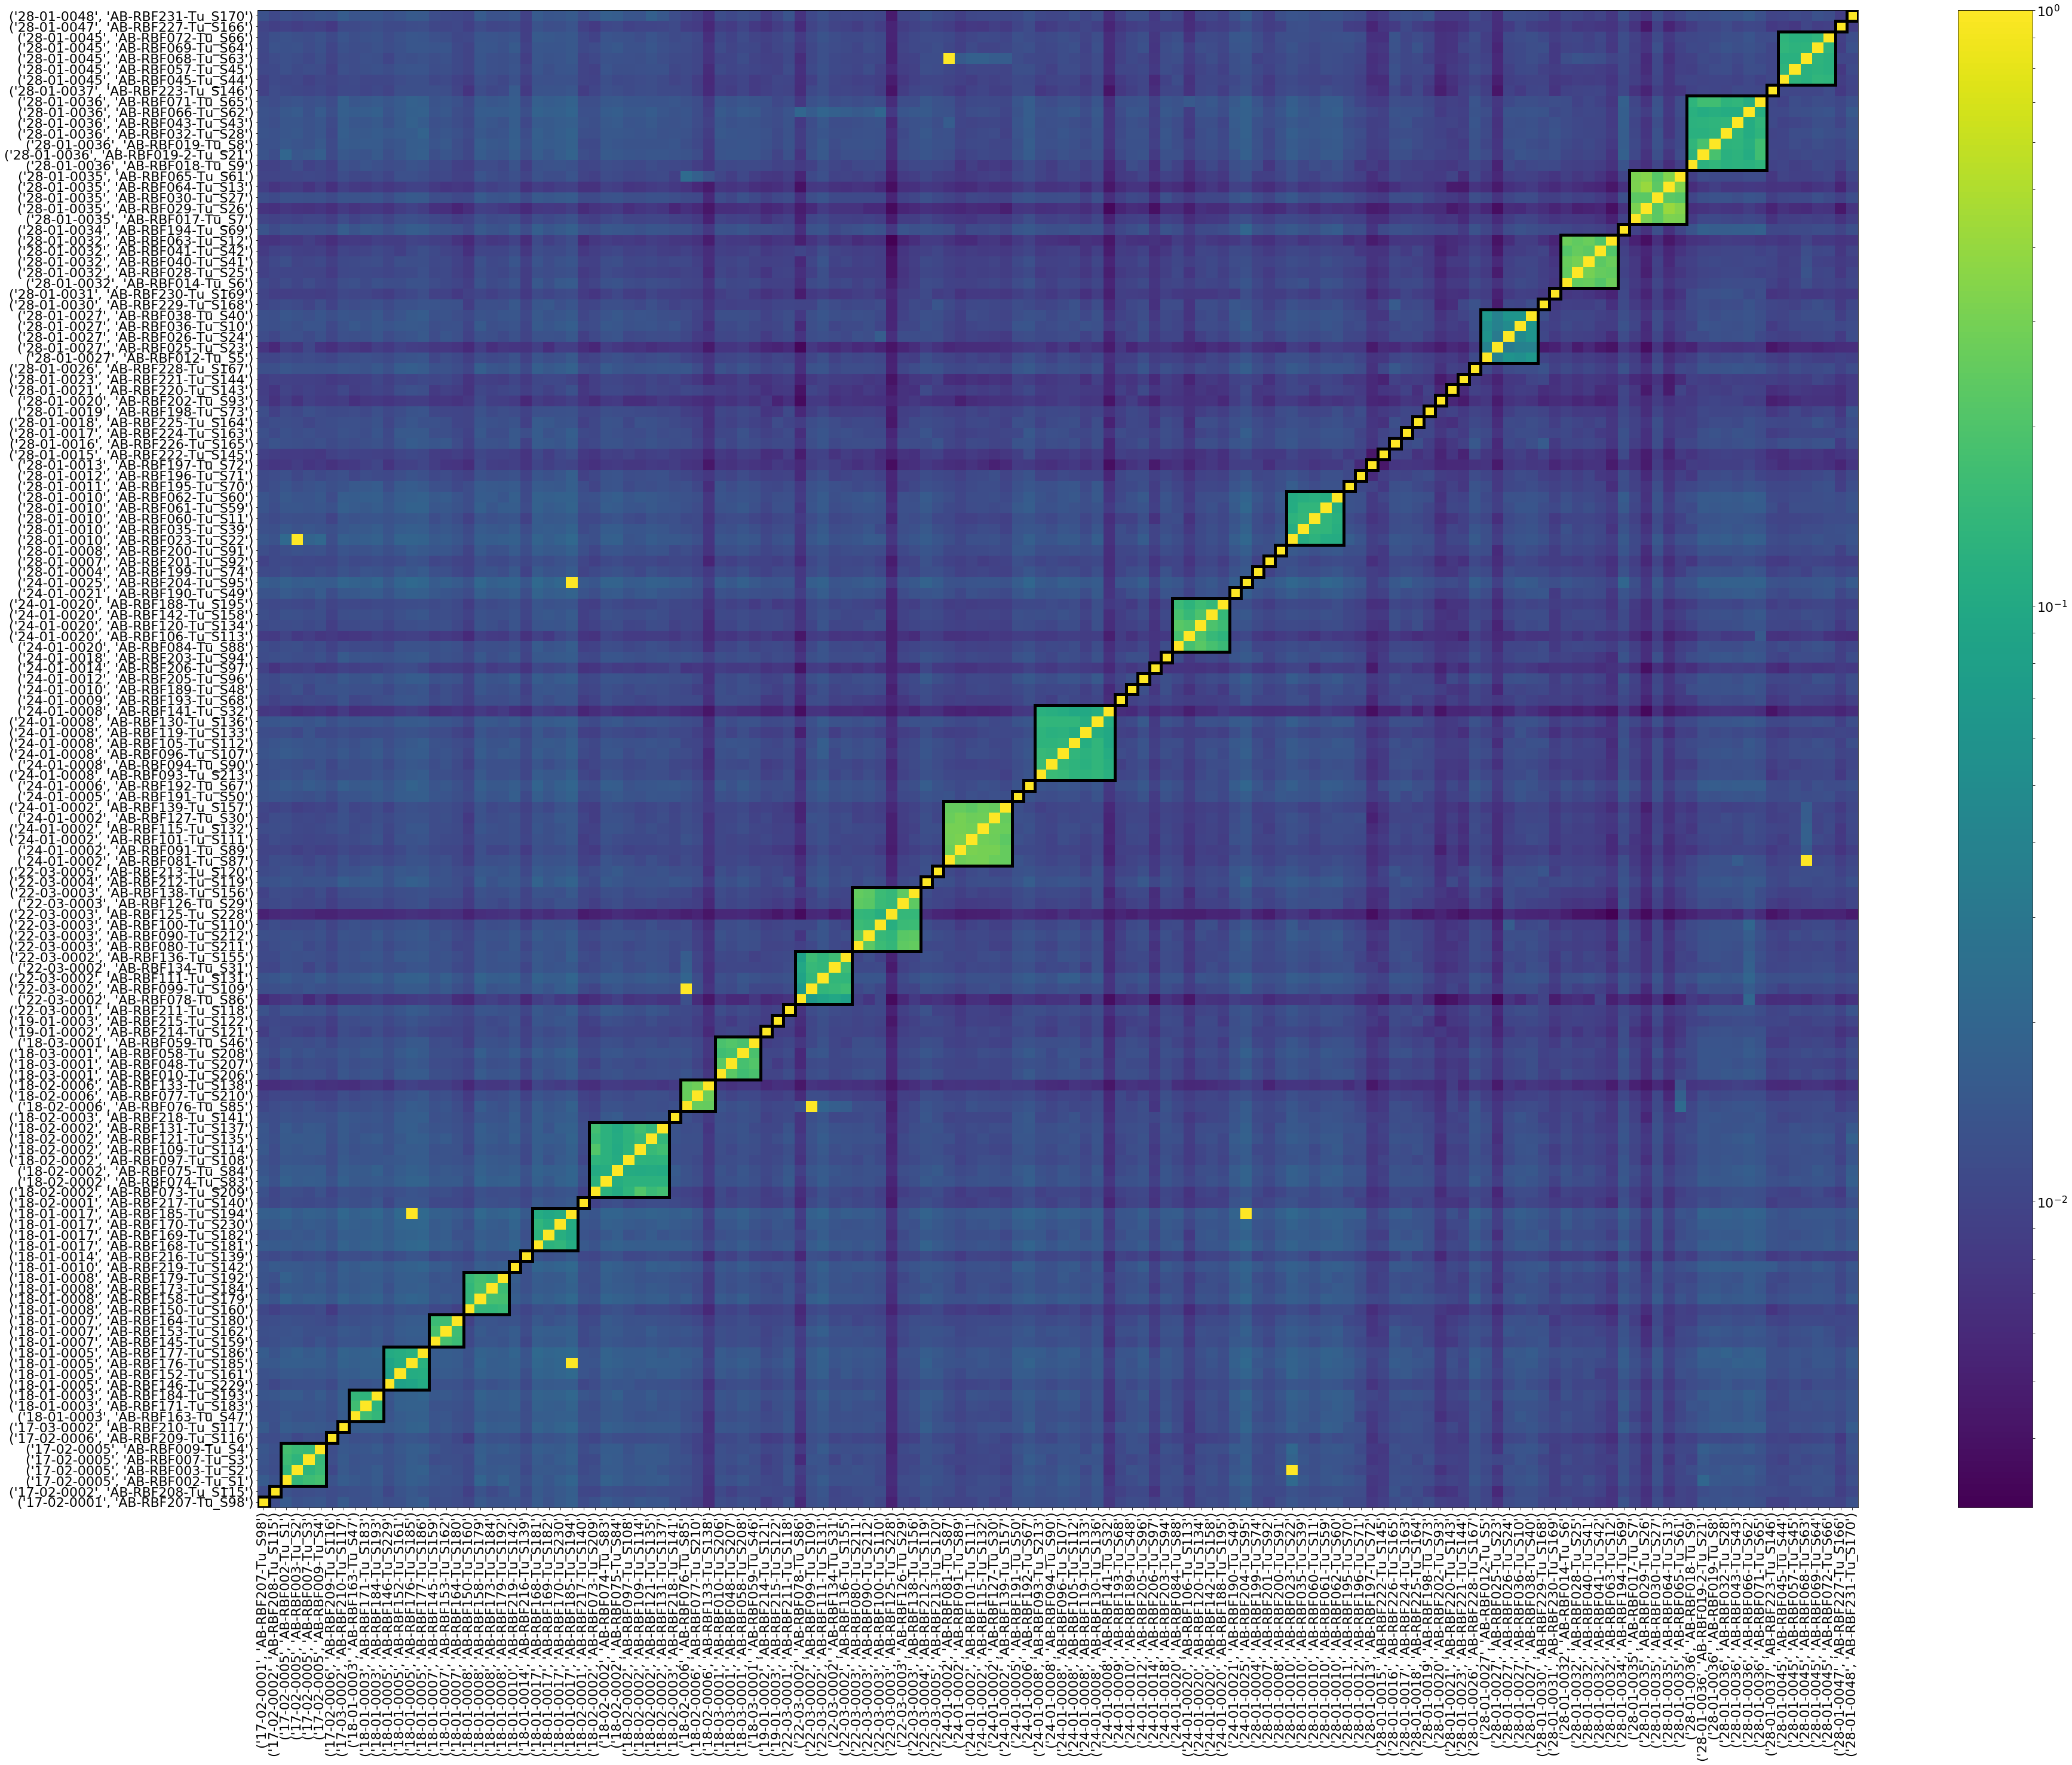

In [21]:
plotfile = plotfile.replace('.pdf', '-2.pdf')
drawHeatmap(sim2)